In [26]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import datetime
from Levenshtein import distance as lev

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap

import requests
from geopy.geocoders import Nominatim

In [27]:
# Set the path to the data folder and the list of folders to be extracted (the files are manually
# repacked into folders according to the type of contamination for ease of processing)
path = 'C:/Users/Konstantin/Documents/Omdena project/data/daily_air_quality_data_2017-2021/'
directories = ['NO2', 'O3', 'PM10', 'PM25']

# Create a function to read .xlsx and put it in a dataframe
def read_xslx_files(file_path, nrows=None, header=0):
    excel_data = pd.read_excel(file_path, nrows=nrows, header=header)
    df = pd.DataFrame(excel_data)
    return df

# Create a function to read the names of files in folders and save to a list
def get_files_names(dir, format='.xlsx'):
    file_list = []
    for root, dirs, files in os.walk(dir, topdown=False):
        for name in files:
            if name.endswith(format):
                file_name = (os.path.join(root, name))
                file_list.append(file_name)
    return file_list

# Load Metadata - station and measurement sites.xlsx to dataframe
df_metadata = read_xslx_files(path + 'Metadata - station and measurement sites.xlsx', None, 0)
codes = df_metadata['Station code'].tolist()

# Create dataframe for processed data
df_full = pd.DataFrame(columns=['DATE', 'POLSTID'])

# Open .xlsx files in each directory one by one
for dir_name in directories:
    file_names_list = get_files_names(path + dir_name)
    # Create dataframe for the resulting dataset for one pollutant
    df_pol_sum = pd.DataFrame(columns=['DATE', 'POLSTID'])
    for file_name in file_names_list:
        # Check the first line of the file against the condition to determine the line number that will be accepted as
        # the heading / column names. This is necessary because all files have a different structure
        df = read_xslx_files(file_name, 1)
        h = 1 if df.columns[1] == 1 or df.columns[1] == '1' else 0
        df = read_xslx_files(file_name, None, h)
        # Determine the line number from which the enumeration of dates begins. Set the flag to do it. This is also
        # necessary due to the different file structure. Simultaneously rename a date column to 'DATE'
        df['flag'] = df.iloc[:, 0].apply(lambda x: 1 if str(x)[:2] == '20' else 0)
        df = df[df['flag'] == 1].drop(columns='flag').rename(columns={'Unnamed: 0': 'DATE', 'Code of the station': 'DATE'})
        # Depending on whether the first file is open in the current folder or not, we create a new or supplement an
        # existing dataframe with data on one type of pollution
        if file_name == file_names_list[0]:
            df_res = df
        else:
            df_res = pd.concat([df_res, df], axis=0, join='outer')
        df_res = df_res.reset_index().drop(columns='index')
    # Convert date to datetime format. Delete data after 31.01.2021
    df_res['DATE'] = pd.to_datetime(df_res['DATE'], errors='coerce').dt.date
    df_res = df_res[df_res.DATE < datetime.date(2022, 1, 1)]
    # Calculate daily averages from average hourly data for O3 pollution
    if dir_name == 'O3':
        df_res_gr = df_res.groupby(['DATE'], as_index=False).mean()
        df_res = df_res_gr
    # Transfer the corresponding station code to each line, as columns of the new dataframe we transfer
    # the pollution values by type.
    pollution_name = dir_name + '_24H_AVG_POLLUTION'
    df_pol_sum.insert(2, pollution_name, None)
    for column in df_res.iloc[:, 1:].columns:
        temp_df = df_res[['DATE', column]].rename(
            {column: pollution_name}, axis=1)
        temp_df.insert(1, 'POLSTID', column)
        df_pol_sum = pd.concat([df_pol_sum, temp_df], axis=0, join='outer')
    # Merge the data on all types of pollutants into one dataframe
    df_full = df_full.merge(df_pol_sum, how='outer', on=['DATE', 'POLSTID'])
    df_full = df_full.reset_index().drop(columns='index')

# Round off the values of the content of O3 in the air to bring them into a single form with the rest of the values.
df_full['O3_24H_AVG_POLLUTION'] = round(df_full['O3_24H_AVG_POLLUTION'], 2)

# Check station codes. If the codes differ by less than 3 characters, compare the coordinates of these stations
# with Metadata - sites of stations and measurements.xlsx. If the coordinates of stations with similar names coincide,
# the pollution readings of these stations are combined into one row.
similar_codes = []
POLSTIDs = df_full.POLSTID.unique().tolist()
for stid in POLSTIDs:
    for stid2 in POLSTIDs:
        diff = lev(stid, stid2)
        if diff > 0 and diff <= 3 and (stid2, stid) not in similar_codes:
            similar_codes.append((stid, stid2))

for elem in similar_codes:
    try:
        coords_s1 = (df_metadata['WGS84 φ N'][df_metadata['Station code'] == elem[0]].unique()[0],
                     df_metadata['WGS84 λ E'][df_metadata['Station code'] == elem[0]].unique()[0])
        coords_s2 = (df_metadata['WGS84 φ N'][df_metadata['Station code'] == elem[1]].unique()[0],
                     df_metadata['WGS84 λ E'][df_metadata['Station code'] == elem[1]].unique()[0])
        if coords1 != coords2:
            continue
    except:
        pass

    # Check which of the codes is in the file with metadata
    if elem[0] not in codes:
        elem = (elem[1], elem[0])
    # Merge the data for stations that have the same coordinates and which codes differ slightly
    try:
        temp_df1 = df_full[df_full.POLSTID == elem[0]]
        indices = df_full[df_full.POLSTID == elem[0]].index
        temp_df2 = df_full[df_full.POLSTID == elem[1]]
        temp_df1 = temp_df1.merge(temp_df2, how='outer', on=['DATE'], suffixes=['', '2'])
        for col in temp_df2.drop(columns=['DATE']).columns:
            temp_df1[col] = temp_df1[col].combine_first(temp_df1.pop(col+'2'))
        temp_df1.set_index(indices, inplace=True)
        df_full[df_full.POLSTID == elem[0]] = temp_df1
        df_full = df_full[df_full.POLSTID != elem[1]]
    except:
        pass

# Add coordinates and place names from Metadata - station and measurement sites.xlsx
df_full = df_full.merge(df_metadata[['Voivodeship', 'City', 'WGS84 φ N', 'WGS84 λ E', 'Station code']],
                        how='left', left_on='POLSTID', right_on='Station code')
df_full = df_full[['DATE', 'POLSTID', 'Voivodeship', 'City', 'WGS84 φ N', 'WGS84 λ E', 'NO2_24H_AVG_POLLUTION',
                   'O3_24H_AVG_POLLUTION', 'PM10_24H_AVG_POLLUTION', 'PM25_24H_AVG_POLLUTION']]
df_full = df_full.rename({'WGS84 φ N': 'LAT', 'WGS84 λ E': 'LON'}, axis=1)

# Using the coordinates and the geopy.geocoders library, we get names cities, counties, states and postcodes
geolocator = Nominatim(user_agent="Konstantin_check_Poland_air_pollution")

# Create a set with coordinates from the columns of the dataframe and in a loop we get the geographical names
# of objects one by one. The received geographic data is placed in a separate list.
coords = set(zip(df_full['LAT'].to_list(), df_full['LON'].to_list()))

geopy_data = []
for coord in coords:
    geo_data = geolocator.reverse(coord)
    geo_data_row = []
    for data in ['city', 'county', 'state', 'postcode']:
        try:
            geo_data_row.append(geo_data.raw['address'][data])
        except:
            geo_data_row.append(np.NaN)
    geopy_data.append(geo_data_row + [coord[0], coord[1]])

# The resulting list with geographical names is placed in a separate dataframe
df_geo = pd.DataFrame(data=geopy_data, columns=['city', 'county', 'state', 'postcode', 'LAT', 'LON'])

#  In a separate dataframe we place data from https://en.wikipedia.org/wiki/List_of_counties_of_Poland
df_wiki = pd.read_csv(path + 'county_table_Wiki.csv')

# Create a list of cities for which the names of counties are not specified, as well as a list of county
# seats from https://en.wikipedia.org/wiki/List_of_counties_of_Poland
no_county_cities = df_geo.city[df_geo.county.isna()].tolist()
county_seat_list = df_wiki.County[df_wiki['County seat'] == 'city county'].tolist()

# Check if the city is a county seat and assigning the county name the same as the city name if so
for city in no_county_cities:
    if city in county_seat_list:
        df_geo.county[df_geo.city == city] = 'powiat ' + city
    else:
        pass

# Create a list with the coordinates of stations for which the names of the county and the postal code are missing
lat_list = df_geo.LAT[df_geo.county.isna() | df_geo.postcode.isna()].tolist()
lon_list = df_geo.LON[df_geo.county.isna() | df_geo.postcode.isna()].tolist()
city_country_list = list(zip(lat_list, lon_list))

# Create a separate dataframe for data from Geonames.org
df_geonames = pd.DataFrame(columns=['LAT', 'LON', 'postcode', 'county'])

# Connect Geonames.org via API and download the missing postal codes and county
for elem in city_country_list:
    try:
        params = {'lat': elem[0], 'lng': elem[1], 'username': 'skrkonst', 'maxRows': 1}
        response = requests.post('http://api.geonames.org/findNearbyPostalCodesJSON?', data=params, timeout=10)
        results = response.json()['postalCodes']
        row = {'LAT': elem[0], 'LON': elem[1], 'postcode': results[0].get('postalCode'), 'county': results[0].get('adminName2')}
        # Place the received data in a previously created dataframe
        df_geonames = df_geonames.append(row, ignore_index=True)
    except:
        pass

df_geonames.county = df_geonames.county.apply(lambda x: x.lower())
# Merge dataframes with geodata received from geonames.org and geopy
df_geo = df_geo.merge(df_geonames, how='left', on=['LAT', 'LON'], suffixes=['', '2'])
df_geo['postcode'] = df_geo['postcode'].combine_first(df_geo.pop('postcode2'))
df_geo['county'] = df_geo['county'].combine_first(df_geo.pop('county2'))

# Complemente the air pollution dataframe with geographic data
df_full = df_full.merge(df_geo[['county', 'postcode', 'LAT', 'LON']], how='left', on=['LAT', 'LON'])
df_full = df_full[['DATE', 'POLSTID', 'Voivodeship', 'City', 'county', 'postcode', 'LAT', 'LON',
                   'NO2_24H_AVG_POLLUTION', 'O3_24H_AVG_POLLUTION', 'PM10_24H_AVG_POLLUTION', 'PM25_24H_AVG_POLLUTION']]

# Replace the powiat names for the station code LbZamoHrubie and "powiat karkonoski" with "powiat jeleniogórski" 
# to ensure full match of geographical names in all datasets
df_full.county = df_full.apply(lambda x: 'powiat Zamość' if x.POLSTID == 'LbZamoHrubie' else x.county, axis=1)
df_full.county = df_full.county.apply(lambda x: 'powiat jeleniogórski' if x == 'powiat karkonoski' else x)

# Sort by dates, and for each date - in alphabetical order by station codes
df_full.sort_values(['DATE', 'POLSTID'], inplace=True)
df_full = df_full.reset_index().drop(columns='index')

df_full.to_csv(f'{path + "cleaned/" + "Combined_all_air_pollut_types&coords"}.csv', index=False)
df_full.head()

,DATE,POLSTID,Voivodeship,City,county,postcode,LAT,LON,NO2_24H_AVG_POLLUTION,O3_24H_AVG_POLLUTION,PM10_24H_AVG_POLLUTION,PM25_24H_AVG_POLLUTION
0,2017-01-01,DsBoleslaMOB,DOLNOŚLĄSKIE,Bolesławiec,powiat bolesławiecki,59-700,51.263245,15.570354,NaN,NaN,NaN,NaN
1,2017-01-01,DsCzerStraza,DOLNOŚLĄSKIE,Czerniawa,powiat lubański,59-850,50.912475,15.312190,NaN,90.39,NaN,NaN
2,2017-01-01,DsGlogWiStwo,DOLNOŚLĄSKIE,Głogów,powiat głogowski,67-200,51.657022,16.097822,NaN,NaN,30.68,NaN
3,2017-01-01,DsJaworMOB,DOLNOŚLĄSKIE,Jawor,powiat jaworski,59-400,51.049212,16.202317,NaN,NaN,NaN,NaN
4,2017-01-01,DsJelGorOgin,DOLNOŚLĄSKIE,Jelenia Góra,powiat Jelenia Góra,58-506,50.913433,15.765608,NaN,11.98,NaN,NaN


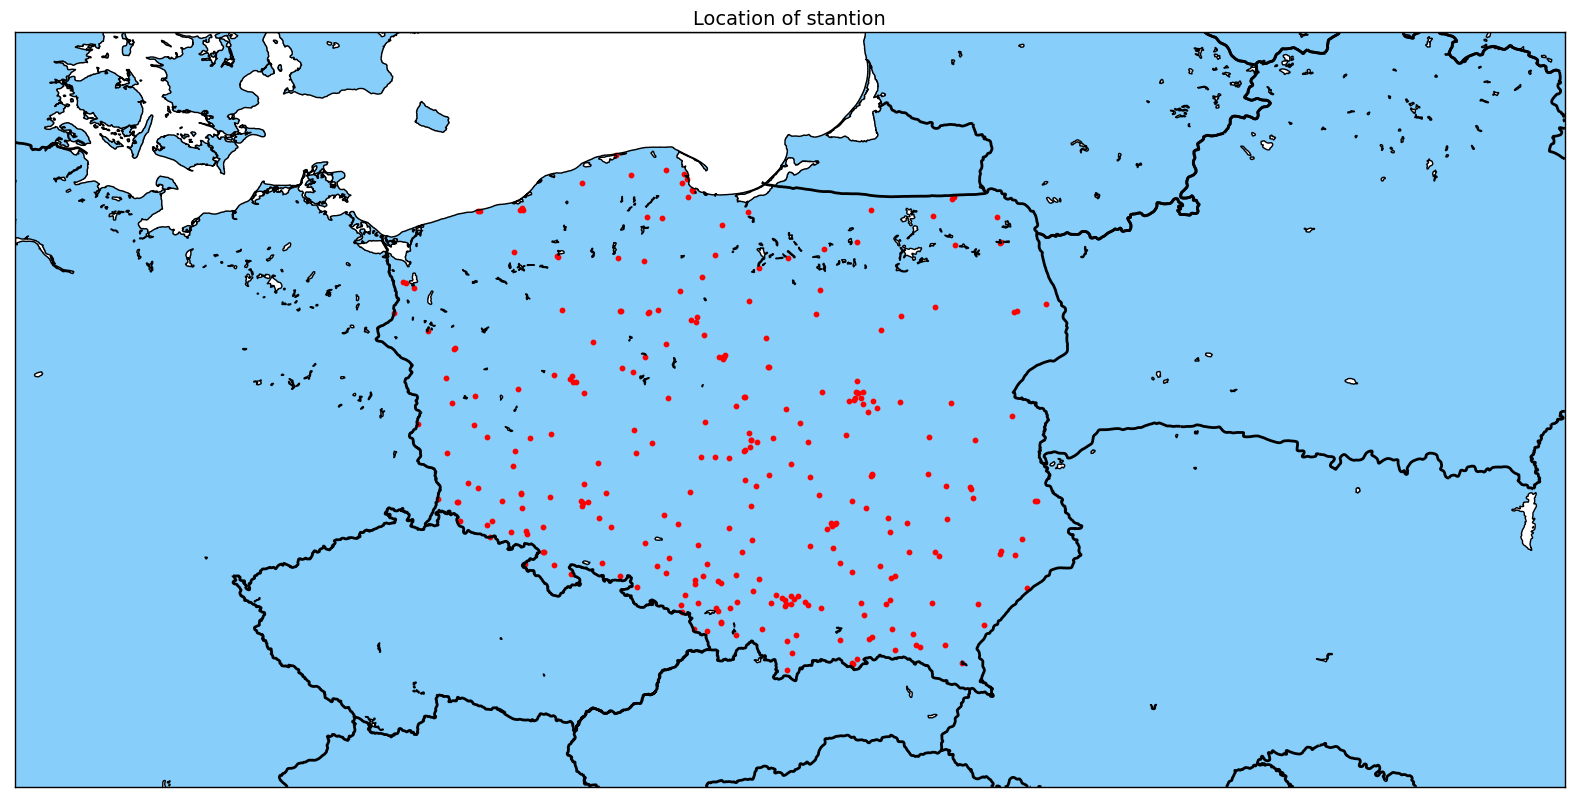

In [32]:
# Display locations of stantions on the map by coordinates
lat = df_full.LAT.unique().tolist()
lon = df_full.LON.unique().tolist()

plt.figure(figsize=(20,10))
m = Basemap(projection='mill', lon_0=20, llcrnrlat=48, urcrnrlat=56, llcrnrlon=9, urcrnrlon=31, resolution='f') 
x, y = m(lon,lat)
m.drawcoastlines()
m.drawcountries(linewidth=2, linestyle='solid', color='k' )
m.fillcontinents(color='lightskyblue',lake_color='white')
m.drawmapboundary(fill_color='white')

m.scatter(x,y,10,marker='o',color='red')
plt.title("Location of stantion", fontsize=14)
plt.show()